In [33]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import time

import fannypack
from lib import dpf, panda_models, panda_datasets, panda_training, fusion_pf, fusion

print(torch.__version__, np.__version__)

1.4.0 1.18.1


In [38]:
# Experiment configuration
experiment_name = "pf_fusion_biggerdataset"
dataset_args = {
    'use_proprioception': True,
    'use_haptics': True,
    'use_vision': True,
    'vision_interval': 2,
}

In [39]:
dynamics_trainset = panda_datasets.PandaDynamicsDataset(
    "data/gentle_push_1000.hdf5",
    **dataset_args
)
dynamics_recurrent_trainset = panda_datasets.PandaSubsequenceDataset(
    "data/gentle_push_1000.hdf5",
    subsequence_length=16,
    **dataset_args
)
measurement_trainset = panda_datasets.PandaMeasurementDataset(
    "data/gentle_push_1000.hdf5",
    samples_per_pair=10,
    **dataset_args
)
e2e_trainset = panda_datasets.PandaParticleFilterDataset(
    "data/gentle_push_1000.hdf5",
    subsequence_length=16,
    particle_count=30,
    particle_stddev=(.1, .1),
    **dataset_args
)

Parsed data: 176075 active, 62925 inactive
Keeping: 62925



Loaded 240000 points
Parsed data: 13331 active, 1669 inactive
Keeping (inactive): 1669


In [40]:
# Create models & training buddy

pf_image_model = panda_models.PandaParticleFilterNetwork(
    panda_models.PandaDynamicsModel(),
    panda_models.PandaMeasurementModel(missing_modalities=['gripper_force', 'gripper_pos']),
)

pf_force_model = panda_models.PandaParticleFilterNetwork(
    panda_models.PandaDynamicsModel(),
    panda_models.PandaMeasurementModel(missing_modalities=['image']),
)

weight_model = fusion.CrossModalWeights(state_dim=1)

pf_fusion_model = fusion_pf.ParticleFusionModel(
    pf_image_model,
    pf_force_model,
    weight_model
)

buddy = fannypack.utils.Buddy(
    experiment_name,
    pf_fusion_model,
    optimizer_names=[
        "e2e_fusion",
        "e2e_image",
        "e2e_force",
        "dynamics_image",
        "dynamics_force",
        "dynamics_recurrent_image",
        "dynamics_recurrent_force",
        "measurement_image",
        "measurement_force",
    ]
)

[buddy-pf_fusion_biggerdataset] Using device: cuda
[buddy-pf_fusion_biggerdataset] No checkpoint found


# Dynamics pre-training

In [41]:
# Dynamics pre-training! (non-recurrent)
models = [
    (pf_image_model, 'dynamics_image'),
#     (pf_force_model, 'dynamics_force'),
]
dataloader = torch.utils.data.DataLoader(dynamics_trainset, batch_size=32, shuffle=True, num_workers=2)

for pf_model, optim_name in models:
    for i in range(2):
        print("Training epoch", i)
        panda_training.train_dynamics(buddy, pf_model, dataloader, log_interval=1, optim_name=optim_name)
        print()

buddy.save_checkpoint()
# Our dynamics models are the same for now, so we can just copy the parameters over
buddy.load_checkpoint_module(source='dynamics_image', target='dynamics_force')

buddy.save_checkpoint("phase_0_dynamics_pretrain")




Training epoch 0



Epoch loss: 0.002436914

Training epoch 1


[buddy-pf_fusion_biggerdataset] Saved checkpoint to path: checkpoints/pf_fusion_biggerdataset-0000000000010000.ckpt

Epoch loss: 0.0021328772

Training epoch 2


KeyboardInterrupt: 

In [42]:
# Dynamics pre-training! (recurrent)
models = [
    (pf_image_model, 'dynamics_recurrent_image'),
#     (pf_force_model, 'dynamics_recurrent_force'),
]
dataloader = torch.utils.data.DataLoader(dynamics_recurrent_trainset, batch_size=32, shuffle=True, num_workers=2)

for pf_model, optim_name in models:
    for i in range(3):
        print("Training epoch", i)
        panda_training.train_dynamics_recurrent(buddy, pf_model, dataloader, log_interval=1, loss_type='l2', optim_name=optim_name)

buddy.save_checkpoint()
# Our dynamics models are the same for now, so we can just copy the parameters over
buddy.load_checkpoint_module(source='image_model.dynamics_model', target='force_model.dynamics_model')

buddy.save_checkpoint("phase_1_dynamics_pretrain_recurrent")

Training epoch 0



Epoch loss: 0.0017458713
Training epoch 1



Epoch loss: 0.0008156936
Training epoch 2



Epoch loss: 0.0005433894
[buddy-pf_fusion_biggerdataset] Saved checkpoint to path: checkpoints/pf_fusion_biggerdataset-0000000000019205.ckpt
[buddy-pf_fusion_biggerdataset] Read checkpoint from path: checkpoints/pf_fusion_biggerdataset-0000000000019205.ckpt


AssertionError: Nonexistent target module!

# Measurement pre-training

In [46]:
models = [
#     (pf_image_model, 'measurement_image'),
    (pf_force_model, 'measurement_force'),
]
measurement_trainset_loader = torch.utils.data.DataLoader(
    measurement_trainset,
    batch_size=32,
    shuffle=True,
    num_workers=16)
for pf_model, optim_name in models:
    for i in range(1):
        print("Training epoch", i)
        panda_training.train_measurement(buddy, pf_model, measurement_trainset_loader, log_interval=20, optim_name=optim_name)

buddy.save_checkpoint("phase_2_measurement_pretrain")

Training epoch 0


[buddy-pf_fusion_biggerdataset] Saved checkpoint to path: checkpoints/pf_fusion_biggerdataset-0000000000080000.ckpt
[buddy-pf_fusion_biggerdataset] Saved checkpoint to path: checkpoints/pf_fusion_biggerdataset-0000000000090000.ckpt
[buddy-pf_fusion_biggerdataset] Saved checkpoint to path: checkpoints/pf_fusion_biggerdataset-0000000000100000.ckpt
[buddy-pf_fusion_biggerdataset] Saved checkpoint to path: checkpoints/pf_fusion_biggerdataset-0000000000110000.ckpt
[buddy-pf_fusion_biggerdataset] Saved checkpoint to path: checkpoints/pf_fusion_biggerdataset-0000000000120000.ckpt
[buddy-pf_fusion_biggerdataset] Saved checkpoint to path: checkpoints/pf_fusion_biggerdataset-0000000000130000.ckpt
[buddy-pf_fusion_biggerdataset] Saved checkpoint to path: checkpoints/pf_fusion_biggerdataset-0000000000140000.ckpt
[buddy-pf_fusion_biggerdataset] Saved checkpoint to path: checkpoints/pf_fusion_biggerdataset-0000000000150000.ckpt

Epoch loss: 106.25267
[buddy-pf_fusion_biggerdataset] Saved checkpoint 

# End-to-end training (individual)

In [47]:
models = [
    (pf_image_model, 'e2e_image'),
    (pf_force_model, 'e2e_force'),
]
for pf_model, optim_name in models:
    pf_model.freeze_measurement_model = False
    pf_model.freeze_dynamics_model = True
    e2e_trainset_loader = torch.utils.data.DataLoader(e2e_trainset, batch_size=32, shuffle=True, num_workers=2)
    for i in range(5):
        print("Training epoch", i)
        panda_training.train_e2e(buddy, pf_model, e2e_trainset_loader, loss_type="mse", optim_name=optim_name)

Training epoch 0



Epoch loss: 0.0018788112
Training epoch 1



Epoch loss: 0.0011229209
Training epoch 2



Epoch loss: 0.0017178588
Training epoch 3



Epoch loss: 0.0019784528
Training epoch 4



Epoch loss: 0.00087735074
Training epoch 0



Epoch loss: 0.0035246804
Training epoch 1



Epoch loss: 0.005199648
Training epoch 2



Epoch loss: 0.0031219902
Training epoch 3



Epoch loss: 0.002638784
Training epoch 4



Epoch loss: 0.00387303


# End-to-end training (fusion)

In [ ]:
optim_name = "e2e_fusion"
pf_model = pf_fusion_model
pf_model.freeze_image_model = False
pf_model.freeze_force_model = False
pf_model.image_model.freeze_dynamics_model = False
pf_model.force_model.freeze_dynamics_model = False
e2e_trainset_loader = torch.utils.data.DataLoader(e2e_trainset, batch_size=32, shuffle=True, num_workers=2)
for i in range(5):
    print("Training epoch", i)
    panda_training.train_e2e(buddy, pf_model, e2e_trainset_loader, loss_type="mse", optim_name=optim_name)
buddy.save_checkpoint("phase_3_trained_e2e_unfreezedimageforce")

Training epoch 0


[buddy-pf_fusion_biggerdataset] Read checkpoint from path: checkpoints/pf_fusion_biggerdataset-phase_3_trained_e2e.ckpt
[buddy-pf_fusion_biggerdataset] Loaded checkpoint at step: 159018
phase_3_trained_e2e


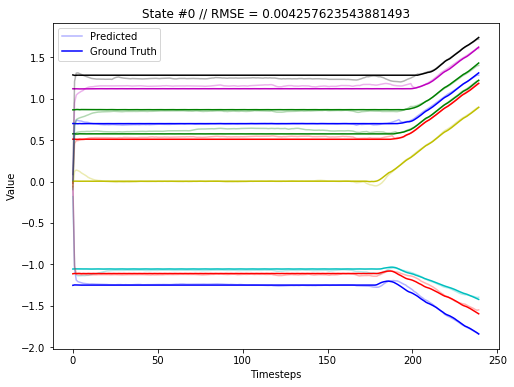

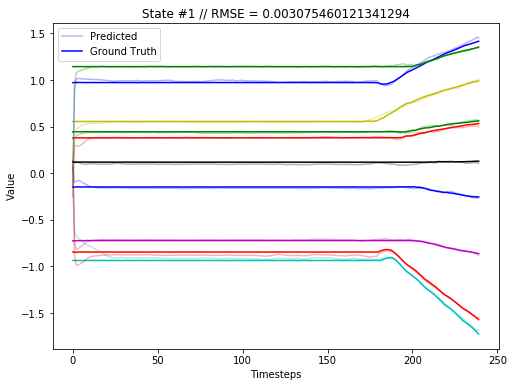

In [58]:
eval_trajectories = panda_datasets.load_trajectories(
    "data/gentle_push_10.hdf5",
    **dataset_args
)
phases = [
#     'phase_0_dynamics_pretrain',
#     'phase_1_dynamics_pretrain_recurrent',
#     'phase_2_measurement_pretrain',
    'phase_3_trained_e2e'
]   
pf_model.image_model.dynamics_model.state_noise_stddev = (0.01, 0.01)
pf_model.force_model.dynamics_model.state_noise_stddev = (0.01, 0.01)

for phase in phases:
    buddy.load_checkpoint(phase)
    print(phase)
    pred, actual = panda_training.rollout(pf_model, eval_trajectories, start_time=0, max_timesteps=1000, particle_count=200, noisy_dynamics=True)
    panda_training.eval_rollout(pred, actual, plot=True)